
 **ΕΠ08 Αναγνώριση Προτύπων – Μηχανική Μάθηση**

 **2 η Εργασία**

Όνομα : Αρβανίτης Κωνσταντίνος

ΑΜ : 1115217000007


[Ερώτημα 1: Αναγνώριση Προσώπων (Face recognition)]

Αρχικά έφτιαξα μία συνάρτηση , η οποία παίρνει ως όρισμα το path που βρίσκεται ο φάκελος των δεδομένων faces (ο φάκελος που υπάρχει στο e-class) και ταξινομώ τις εικόνες όπως ζητείται στην εκφώνηση , σε υποφακέλους
Set_1,Set_2,..,Set_5

In [ ]:

import os
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import shutil


# Function that organizes photos given in the "faces" folder into 5 sets of data
def organize(path):
    sets = ["Set_1", "Set_2", "Set_3", "Set_4", "Set_5"]

    for set_name in sets:
        dir_path = os.path.join(path, set_name)

        if not os.path.isdir(dir_path):
            os.mkdir(dir_path, 0o666)

    for photo in os.listdir(path):
        if photo in sets:
            continue

        index0 = int(photo[9])
        index1 = int(photo[10])

        if (index0 == 0 and index1 < 8) or ((index0 == 0 and index1 > 7) or index0 == 1):
            set_idx = 0
        elif index0 == 2 or (index0 == 3 and index1 < 2):
            set_idx = 2
        elif (index0 == 3 and index1 > 1) or (index0 == 4 and index1 < 6):
            set_idx = 3
        else:
            set_idx = 4

        dir_path = os.path.join(path, sets[set_idx])
        prev_path = os.path.join(path, photo)
        new_path = os.path.join(dir_path, photo)

        shutil.move(prev_path, new_path)

Παρακάτω είναι η loadImages συνάρτηση που ικανοποιεί το πρώτο ζητούμενο της εκφώνησης , παίρνει τις εικόνες και φτιάχνει τα labels

In [ ]:
# Function to load images and labels from a specific set
def loadImages(path, set_number):
    image_paths = []
    labels = []

    set_path = os.path.join(path, set_number)
    for filename in os.listdir(set_path):
        image_path = os.path.join(set_path, filename)
        image = Image.open(image_path).convert("L")  # Convert to grayscale
        image_array = np.array(image).flatten()  # Flatten image into a column vector
        image_paths.append(image_array)

        # Extract the label from the filename
        label = int(filename.split("_")[0].replace("person", ""))
        labels.append(label)

    images = np.column_stack(image_paths)  # Stack image vectors horizontally
    labels = np.array(labels)

    return images, labels

Στην συνέχεια υλοποιώ τον αλγόριθμο eigenfaces , ο οποίος ακολουθεί τα παρακάτω βήματα

1.   Μετατρέπει τις εικόνες σε grayscale και τους αλλάζει μέγεθος.
2.   Φτιάχνει το face space κκαι μετατρέπει τις εικόνες σε vectors.
3.   Υπολογίζει το mean face από τα face vectors.
4.   Υπολογίζει το covariance matrix των centered face vectors.
5.   Εφαρμόζει eigendecomposition για να πάρουμε τα eigenvalues και eigenvectors.
6.   Διαλέγει τα πρώτα eigenfaces με βάση τον αριθμο των eigenfaces που χρειαζόμαστε.
7.   Τέλος , προβάλει τα training images στο eigenfaces subspace.








In [ ]:
# Function to perform eigenfaces algorithm
def eigenfaces_algorithm(path, image_size, num_eigenfaces):

    def preprocess_image(image_path):
        image = Image.open(image_path).convert("L")  # Convert to grayscale
        image = image.resize(image_size)  # Resize to a consistent size
        return np.array(image)

    def build_face_space(image_paths):
        face_space = []
        for image_path in image_paths:
            image = preprocess_image(image_path)
            face_vector = image.flatten()
            face_space.append(face_vector)
        return np.array(face_space)

    def calculate_mean_face(face_space):
        mean_face = np.mean(face_space, axis=0)
        return mean_face

    def compute_covariance_matrix(face_space, mean_face):
        centered_faces = face_space - mean_face
        covariance_matrix = np.cov(centered_faces, rowvar=False)
        return covariance_matrix

    def perform_eigendecomposition(covariance_matrix):
        eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
        eigenvectors = eigenvectors.T  # Transpose to have eigenvectors as rows
        sorted_indices = np.argsort(eigenvalues)[::-1]  # Sort indices in descending order
        sorted_eigenvalues = eigenvalues[sorted_indices]
        sorted_eigenvectors = eigenvectors[sorted_indices]
        return sorted_eigenvalues, sorted_eigenvectors

    def select_top_eigenfaces(eigenvalues, eigenvectors, num_eigenfaces):
        top_eigenvalues = eigenvalues[:num_eigenfaces]
        top_eigenvectors = eigenvectors[:num_eigenfaces]
        return top_eigenvalues, top_eigenvectors

    # Step 7: Project the training images onto the eigenfaces
    def project_images(face_space, mean_face, top_eigenvectors):
        centered_faces = face_space - mean_face
        projected_faces = np.dot(centered_faces, top_eigenvectors.T)
        return projected_faces

    organize(path)

    #Collect image paths for training
    training_image_paths = []
    for set_name in os.listdir(path):
        set_path = os.path.join(path, set_name)
        if os.path.isdir(set_path):
            training_image_paths.extend([os.path.join(set_path, filename) for filename in os.listdir(set_path)])

    #Build the face space
    face_space = build_face_space(training_image_paths)

    #Calculate the mean face
    mean_face = calculate_mean_face(face_space)

    #Compute the covariance matrix
    covariance_matrix = compute_covariance_matrix(face_space, mean_face)

    #Perform eigendecomposition
    eigenvalues, eigenvectors = perform_eigendecomposition(covariance_matrix)

    #Select the top eigenfaces
    top_eigenvalues, top_eigenvectors = select_top_eigenfaces(eigenvalues, eigenvectors, num_eigenfaces)

    #Project the training images onto the eigenfaces
    projected_faces = project_images(face_space, mean_face, top_eigenvectors)

Η συνάρτηση eigenfaces_classification , φορτώνει τις εικόνες από την loadImages function και εφαρμόζει PCA στις training and test εικόνες και εφαρμόζει  KNN classification για προβλέψει τα labels για τις τεστ εικόνες .Τέλος υπολογίζει την ακρίβεια της εκπαίδευσης

In [ ]:
def eigenfaces_classification(train_set, test_sets, d_values):
    train_images, train_labels = loadImages(dataset_path, train_set)

    accuracies = []

    for d in d_values:
        # Perform PCA on the training set
        pca = PCA(n_components=d)
        pca.fit(train_images.T)  # Transpose images for PCA

        # Project training images onto the eigenfaces subspace
        train_projected = pca.transform(train_images.T)

        test_accuracy = []

        for test_set in test_sets:
            test_images, test_labels = loadImages(dataset_path, test_set)

            # Project test images onto the eigenfaces subspace
            test_projected = pca.transform(test_images.T)

            # Use K-Nearest Neighbors classifier to classify the test images
            knn = KNeighborsClassifier(n_neighbors=1)
            knn.fit(train_projected, train_labels)
            predicted_labels = knn.predict(test_projected)

            # Calculate accuracy
            accuracy = accuracy_score(test_labels, predicted_labels)
            test_accuracy.append(accuracy)

        accuracies.append(test_accuracy)

    return accuracies


Εδώ καλείται η παραπάνω συνάρτηση αφού έχουν φορτωθεί οι εικόνες από το Set_1 και αφού βρίσκουμε τα eigenfaces για το Set_1 εκτυπώνουμε τα 9 καλύτερα.

Test Set: Set_1
d=9: Accuracy=1.0
d=30: Accuracy=1.0
Test Set: Set_2
d=9: Accuracy=0.9
d=30: Accuracy=0.9416666666666667
Test Set: Set_3
d=9: Accuracy=0.425
d=30: Accuracy=0.5083333333333333
Test Set: Set_4
d=9: Accuracy=0.2
d=30: Accuracy=0.2
Test Set: Set_5
d=9: Accuracy=0.14736842105263157
d=30: Accuracy=0.14736842105263157


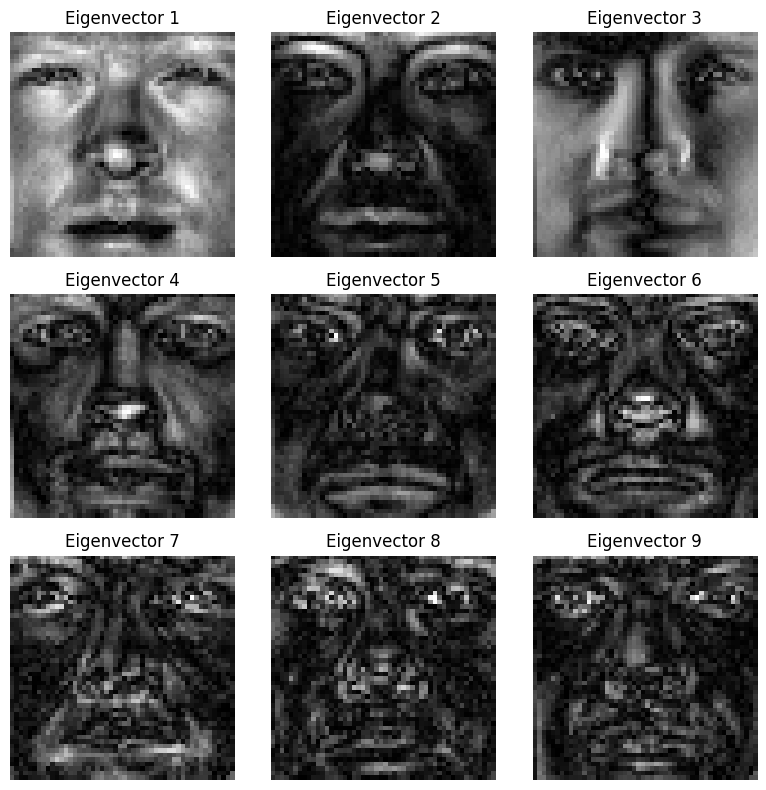

In [ ]:
# Call the eigenfaces_algorithm function with the necessary arguments
dataset_path = "drive/MyDrive/ColabNotebooks/faces/"

sets = ["Set_1", "Set_2", "Set_3", "Set_4", "Set_5"]

images_set1,labels_set1 = loadImages(dataset_path,sets[0])

train_set = "Set_1"
test_sets = ["Set_1", "Set_2", "Set_3", "Set_4", "Set_5"]
d_values = [9, 30]

accuracies = eigenfaces_classification(train_set, test_sets, d_values)

# Print the accuracies for each test set and each d value
for i, test_set in enumerate(test_sets):
    print(f"Test Set: {test_set}")
    for j, d in enumerate(d_values):
        accuracy = accuracies[j][i]
        print(f"d={d}: Accuracy={accuracy}")


# image_size = (50, 50)  # Example size, adjust according to your requirements
# num_eigenfaces = 100  # Example number, adjust as desired
# eigenfaces_algorithm(dataset_path, image_size, num_eigenfaces)

X, y = loadImages(dataset_path, "Set_1")

# Υπολογίστε τον μέσο όρο των δεδομένων
mean_face = np.mean(X, axis=1)

# Υπολογίστε την απόκλιση από τον μέσο όρο
X_centered = X - mean_face[:, np.newaxis]

# Υπολογίστε τον πίνακα συνδιακύμανσης
covariance_matrix = np.cov(X_centered)

# Υπολογίστε τα ιδιοδιανύσματα και τις ιδιοτιμές
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

# Ταξινομήστε τα ιδιοδιανύσματα βάσει των ιδιοτιμών
sorted_indices = np.argsort(eigenvalues)[::-1]  # Αντιστροφή της σειράς

# Επιλέξτε τα 9 κύρια ιδιοδιανύσματα
top_eigenvectors = eigenvectors[:, sorted_indices[:9]]

# Create a figure and subplots
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

# Reshape and display the top 9 eigenvectors
for i, ax in enumerate(axes.flatten()):
    eigenface = np.abs(top_eigenvectors[:, i])  # Take the absolute value of the eigenvector
    eigenface_image = np.reshape(eigenface, (50, 50))  # Reshape to image format
    ax.imshow(eigenface_image, cmap='gray')  # Display the eigenvector as grayscale image
    ax.axis('off')  # Disable axes
    ax.set_title(f"Eigenvector {i+1}")  # Set the title as Eigenface 1, Eigenface 2, etc.

# Adjust the layout of subplots
plt.tight_layout()

# Display the image with the eigenvectors
plt.show()

Εδώ γίνεται η υλοποίηση του ζητούμενου 4 , στο οποίο φτορτώνονται οι εικόνες
περνιούνται από την πάνω συνάρτηση και εκτυπώνονται τα 9 καλύτερα eigenfaces από το Set_1

Εδώ γίνεται η υλοποιήση του ζητούμενου 5 , όπου κάνου SVD analysis στι εικόνες και εκτυπώνουμε τα 9 καλύτερα singular vectors . Παρατηρούμε επίσης , ότι τα singular vectors δεν είναι ορθογωνικά μεταξύ τους , σε αντίθεση με τα eigenvectors ενός συμμετρικού πίνακα. Όμως και τα 2 μας δίνουν πολύ χρήσιμες πληροφορίες για τα δεδομένα

<ipython-input-7-1b76670efc2c>:14: ComplexWarning: Casting complex values to real discards the imaginary part
  reconstructed_face = reconstructed_face.astype(float)


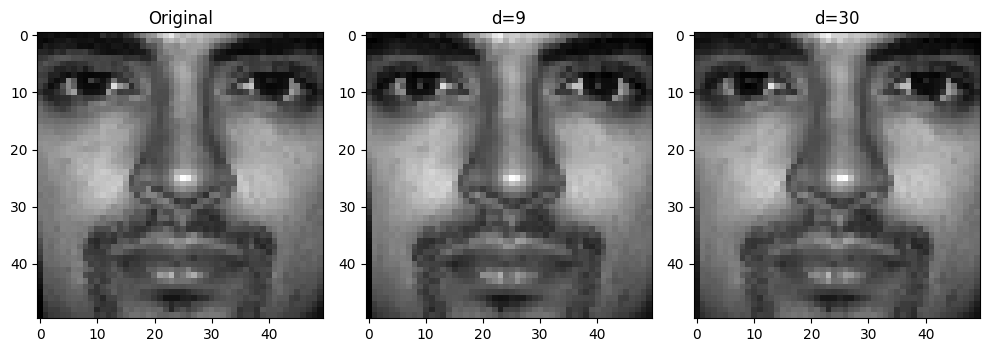

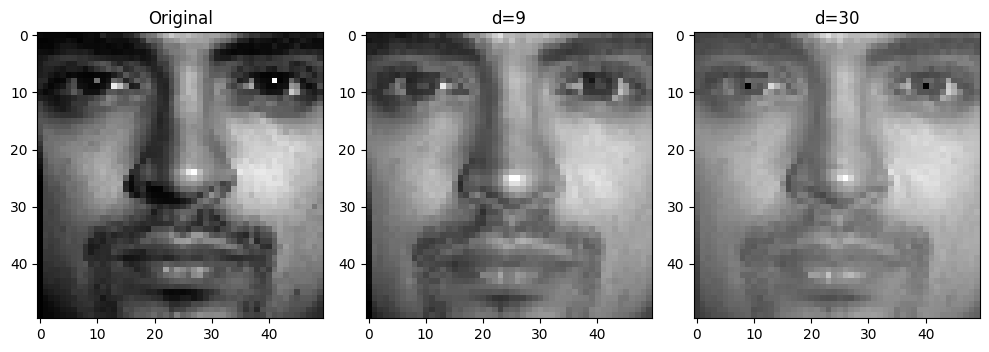

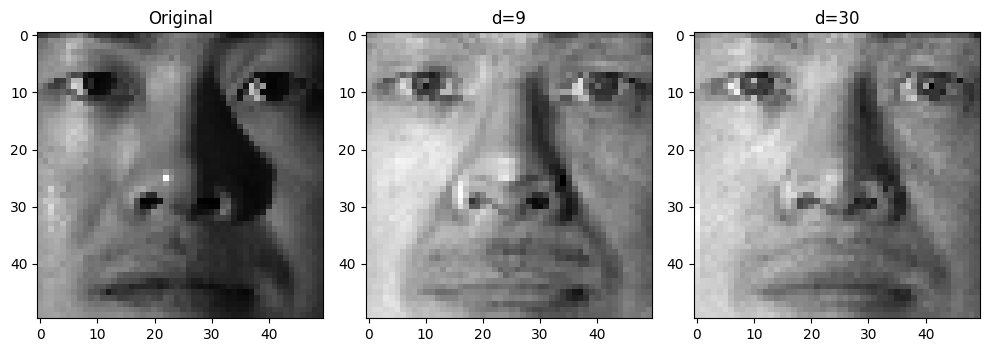

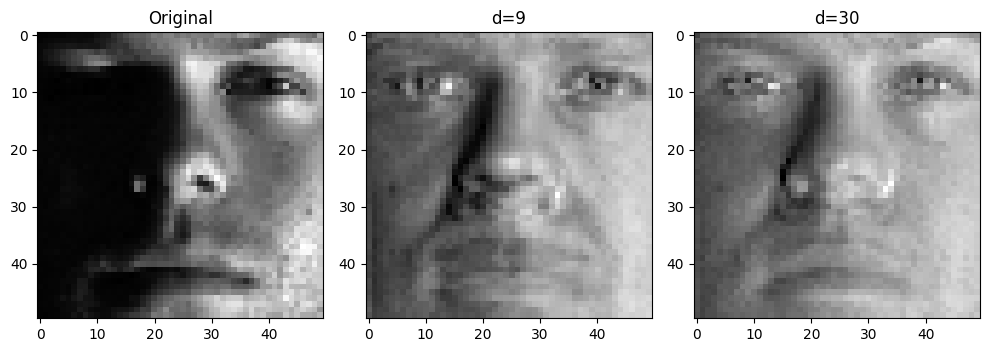

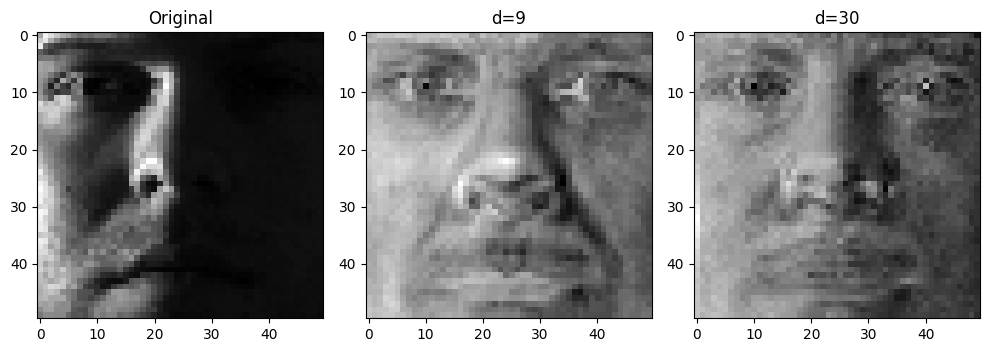

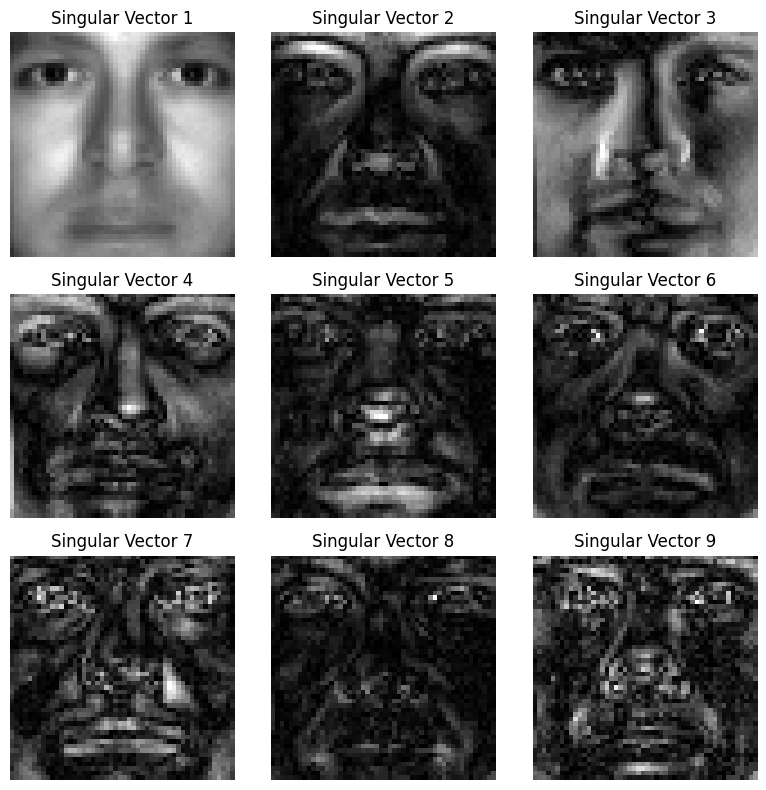

In [ ]:
import random

def reconstruct_image(image, mean_face, top_eigenvectors, d):
    # Project the image onto the eigenfaces subspace
    image_vector = image.flatten()
    centered_face = image_vector - mean_face
    weights = np.dot(centered_face, top_eigenvectors[:, :d])
    reconstructed_face = mean_face + np.dot(weights, top_eigenvectors[:, :d].T)

    # Convert the reconstructed face to float data type
    reconstructed_face = reconstructed_face.astype(float)
    return reconstructed_face.reshape(image.shape)

# Load images and labels from Set_1
set1_images, _ = loadImages(dataset_path, "Set_1")

# Perform eigenfaces algorithm on Set_1
mean_face = np.mean(set1_images, axis=1)
covariance_matrix = np.cov(set1_images - mean_face[:, np.newaxis])
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
sorted_indices = np.argsort(eigenvalues)[::-1]
top_eigenvectors = eigenvectors[:, sorted_indices]

# Randomly select an image from each set
random_images = []
for set_name in sets:
    set_images, _ = loadImages(dataset_path, set_name)
    random_image_index = random.randint(0, set_images.shape[1] - 1)
    random_image = set_images[:, random_image_index]
    random_images.append(random_image)

# Reconstruct and visualize the images for different values of d
d_values = [9, 30]

for random_image in random_images:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, len(d_values) + 1, 1)
    plt.imshow(random_image.reshape(50,50), cmap='gray')
    plt.title("Original")

    for i, d in enumerate(d_values):
        reconstructed_image = reconstruct_image(random_image, mean_face, top_eigenvectors, d)
        plt.subplot(1, len(d_values) + 1, i + 2)
        plt.imshow(reconstructed_image.reshape(50,50), cmap='gray')
        plt.title(f"d={d}")

    plt.tight_layout()
    plt.show()

# Compute SVD on the Set_1 data matrix
U, s, Vt = np.linalg.svd(X)

# Select the top 9 singular vectors
top_singular_vectors = U[:, :9]

# Create a figure and subplots
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

# Reshape and display the top 9 singular vectors
for i, ax in enumerate(axes.flatten()):
    singular_vector = np.abs(top_singular_vectors[:, i])  # Take the absolute value of the singular vector
    singular_vector_image = np.reshape(singular_vector, (50, 50))  # Reshape to image format
    ax.imshow(singular_vector_image, cmap='gray')  # Display the singular vector as grayscale image
    ax.axis('off')  # Disable axes
    ax.set_title(f"Singular Vector {i+1}")  # Set the title as Singular Vector 1, Singular Vector 2, etc.

# Adjust the layout of subplots
plt.tight_layout()

# Display the images with the singular vectors
plt.show()